In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generating a Synthetic Time Series

In time series analysis, an observed series is often represented as the sum of two main components:  

- **Systematic component** – The structured, deterministic part of the series.  
- **Residual correlated noise** – A stochastic process that may exhibit dependence over time.  

The systematic component is typically further decomposed into:

- **Trend** – The long-term directional movement in the data.  
- **Seasonality** – Regular, repeating patterns that occur at fixed intervals.  

The following approach is assumed for generating a **synthetic time series**:

1. Generating a series of **white noise**.  
2. Transforming it into a **correlated process** using an **AR($p$) model**.  
3. Adding a **trend** and **seasonality** to introduce systematic structure.  

## **White Noise**
White noise is a sequence of independent and identically distributed (i.i.d.) random variables, meaning each realization comes from the same distribution and is independent of all others. While a standard normal distribution is a common choice due to its simplicity and mathematical convenience, it is not a strict requirement. The choice of mean, variance, and even distribution is flexible, provided that the white noise remains independent and identically distributed over time.

Here, a series of white noise will be generated as i.i.d. random variables drawn from a standard normal distribution:

$$ \epsilon_t \sim \mathcal{N}(0,1) $$

## **AR($p$) Process**  

An autoregressive process of order $p$, denoted **AR($p$)**, is defined as:  

$$ X_t = \sum_{i = 1}^{p} \phi_i X_{t-i} + \epsilon_t, $$  

where $\epsilon_t$ is white noise.

The stationarity of an **AR($p$) process** is determined by the roots of its **characteristic polynomial**, which can be expressed in two equivalent formulations:  

### **1. Z-transform Representation**

Using the Z-transform, the AR($p$) process can be rewritten as:  

$$ \mathcal{Z}\{X_t\} \left( 1 - \sum_{i=1}^{p} \phi_i z^{-i} \right) = \mathcal{Z}\{\epsilon_t\}, \quad z \in \mathbb{C}. $$  

The characteristic polynomial is then given by:  

$$ 1 - \sum_{i=1}^{p} \phi_i z^{-i} = 0. $$  

Multiplying both sides by $z^p$ yields a polynomial form:  

$$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$  

For the AR($p$) process to be **stationary**, all solutions (roots) of this characteristic equation must lie **inside** the unit circle:  

$$ \forall_i \quad |z_i| < 1. $$  

For the process to remain **real-valued**, the polynomial's roots must satisfy:  

- Any complex roots must occur in **conjugate pairs**.  
- If $p$ is odd, at least one root must be **real**.  

These conditions ensure that the **coefficients** $\phi_i$ remain real.  

### **2. Backshift Operator Representation**  

The **backshift operator** $L$ is defined as:  

$$ L^k X_t = X_{t-k}. $$  

Rewriting the AR($p$) equation in terms of $L$:  

$$ \left(1 - \sum_{i=1}^{p} \phi_i L^i \right) X_t = \epsilon_t. $$  

The characteristic polynomial is then:  

$$ 1 - \sum_{i=1}^{p} \phi_i L^i = 0, $$  

which is equivalent to the Z-transform formulation, where $L$ corresponds to $z^{-1}$.  

The **stationarity condition** in this form requires that **all roots lie outside the unit circle**:  

$$ \forall_i \quad |L_i| > 1. $$  

### **Generating an AR($p$) Process**

To generate an AR($p$) process using the **Z-transform formulation**:

1. **Generate the roots ensuring stationarity**  
   Generate the roots $\{z_i\}_{i=1}^p$ of the characteristic polynomial in the **Z-transform domain**, ensuring that they lie **inside** the unit circle:

   $$ \forall_i \quad |z_i| < 1. $$

2. **Compute AR Coefficients via Vieta’s Formulas**  
   The characteristic polynomial associated with the AR($p$) process is given by:

   $$ z^p - \sum_{i=1}^{p} \phi_i z^{p-i} = 0. $$

   In its factored form:

   $$ \prod_{i=1}^{p} (z - z_i) = z^p + a_1 z^{p-1} + a_2 z^{p-2} + \dots + a_p = z^p - \phi_1 z^{p-1} - \phi_2 z^{p-2} - \dots - \phi_p. $$

   Expanding the left-hand side and matching coefficients term by term, the AR coefficients $\phi_i$ are obtained:

   $$ a_1 = -\sum_{i=1}^{p} z_i, $$

   $$ a_2 = \sum_{1 \le i < j \le p} z_i z_j, $$

   $$ a_3 = -\sum_{1 \le i < j < k \le p} z_i z_j z_k, $$

   and so forth, alternating signs. In general:

   $$ a_m = (-1)^{m} \sum_{1 \le i_1 < i_2 < \dots < i_m \le p} z_{i_1} z_{i_2} \dots z_{i_m}. $$

   These coefficients follow Vieta’s relations, assuming a monic polynomial (i.e., the leading coefficient is 1).

   Then $\phi_1 = -a_1$, $\phi_2 = -a_2$ and so on.

4. **Simulate the AR($p$) Process**  
   Given the computed **AR coefficients** $\phi_1, \phi_2, \dots, \phi_p$ and a **white noise process** $\{\epsilon_t\}$:

   - Initialize $X_1, \dots, X_p$ to zeros.
   - Compute:

     $$ X_t = \sum_{i=1}^{p} \phi_i X_{t-i} + \epsilon_t, \quad t = p+1, p+2, \dots $$

   - To obtain a time series of length $T$, generate $T+M$ data points and discard the first $M$ values to remove the influence of initial conditions.
   - Set $M = 10p$ to ensure minimal impact from initialization.  

This procedure yields a **stationary** AR($p$) time series $\{X_t\}$ based on the **Z-transform formulation**.

## Time frame choice

In [63]:
# Y years of daily data
Y = 3
# My year temporarily has 10 days so it's easier to check
# TODO chage to 365
N = 10 * Y
start_date = pd.to_datetime("2020-01-01")
date_index = pd.date_range(start = start_date, periods = N, freq = 'D')
synth_ts = pd.DataFrame(index = date_index)

## Stationary AR(p)

### Generate roots

In [93]:
def generate_stationary_roots(p):
    """
    Generate p roots for the characteristic polynomial of an AR(p) process.
    Characteristic polynomial is of the form z^p - phi_1*z^p-1 - ... - phi_p-1*z - phi_p = 0
    (Z-transfer approach for characteristic polynomial representation.)
    Complex roots are generated as a pair (radius, angle theta) which then fulfill
    root = radius(cos(theta) + j*sin(theta))
    Ensure conditions:
    - all roots are inside of the unit circle,
    - complex roots occur in conjugate pairs,
    - if p is odd, at least one root is real.

    Returns:
    ndarray: roots of AR(p) characteristic polynomial
    """
    rng = np.random.default_rng()
    
    roots = []
    num_complex_pairs = p // 2  # Number of complex conjugate pairs
    num_real = p % 2  # If p is odd, we need one real root

    # Set small lower bound to avoid trivial terms
    lower_bound = 1e-8

    # Generate complex roots in conjugate pairs
    for _ in range(num_complex_pairs):
        r = rng.uniform(lower_bound, 1)  # Generate length. Ensure |z| < 1
        theta = rng.uniform(0, np.pi)  # Random angle for complex number
        complex_root = r * np.exp(1j * theta)  # Convert to a complex form
        roots.append(complex_root)
        roots.append(np.conj(complex_root))  # Add a conjugate pair

    # If p is odd, add a real root
    if num_real == 1:
        real_root = rng.uniform(lower_bound, 1)  # Ensure |z| < 1
        roots.append(real_root)

    return np.array(roots)

### Compute coefficients

In [82]:
from numpy.polynomial import Polynomial as P

def compute_ar_coefficients(roots):
    """
    Compute AR(p) characteristic polynomial coefficients from the given roots.
    It computes coefficients of the characteristic polynomial of the form:
    z^p - phi_1*z^p-1 - ... - phi_p-1*z - phi_p = 0 (z is a complex number)

    Returns:
    ndarray: [phi_1 phi_2 ... phi_p]
        Coefficients are in form of complex numbers re + im*j.
        If the imaginary part is equal 0, the resulting AR(p) process is real.
    """
    # Get polynomial coefficients from roots
    p = P.fromroots(roots)
    poly_coeffs = p.coef

    # returns as complex numbers, later can be checked if the imaginary part
    # is 0 if process is real valued
    return np.flip(-poly_coeffs[:-1])

In [77]:
from itertools import combinations
def vieta_brute_force(roots):
    """
    Demonstrates Vieta's formulas by computing the coefficients
    of the monic polynomial with the given roots.
    
    For a polynomial with p roots each coefficient (for k = 1, …, p)
    is the sum of the products of all k-element combinations of the roots:

    a_k = sum (z_{i1} * z_{i2} * ... * z_{ik}) 
    over all k-element subsets {i1, i2, …, ik} of {1, 2, …, p}.

    By Vieta’s formulas, the coefficient of x^(p-k) is (-1)^k * a_k.

    NOTE: This implementation explicitly generates all k-element combinations,
    leading to EXPONENTIAL COMPLEXITY.
    It is for educational purposes only and should not be used for large inputs.
    """
    p = len(roots)
    coefficients = []  # will hold the coefficients for x^(p-1), x^(p-2), ..., x^0

    # Loop over k = 1, 2, ..., p (number of roots to multiply)
    for k in range(1, p+1):
        a_k = 0
        # Iterate over all combinations of roots taken k at a time.
        for combo in combinations(roots, k):
            product = 1
            for z in combo:
                product *= z
            a_k += product
        # According to Vieta's formulas, the coefficient for x^(p-k) is (-1)^k * phi_k.
        coefficient = (-1)**(k) * a_k
        coefficients.append(coefficient)
    return coefficients

In [78]:
def calculate_vietas_coeffs(roots):
    """
    Computes the coefficients of a monic polynomial given its roots
    using Vieta's formulas. For a polynomial with p roots:

    (x - r1) * (x - r2) * ... * (x - rp) 
    = x^p - phi_1*x^(p-1) + phi_2*x^(p-2) - ... + (-1)^p * phi_p,

    each phi_k (for k = 1, …, p) is the sum of the products
    of all k-element combinations of the roots:

    phi_k = sum (r_{i1} * r_{i2} * ... * r_{ik}) 
    over all k-element subsets {i1, i2, …, ik} of {1, 2, …, p}.

    By Vieta’s formulas, the coefficient of x^(p-k) is (-1)^k * phi_k.

    This function computes the phi_k values using dynamic programming,
    avoiding the exponential complexity of a brute-force approach.
    """
    p = len(roots)
    # Initialize the list: phi[0] = 1, phi[1...n] = 0
    phi = [1] + [0] * p

    # Update phi for each root
    for r in roots:
        for j in range(p, 0, -1):
            phi[j] -= r * phi[j-1]

    # phi[k] is (-1)**k * (sum of products of k roots)
    # Print the values for k = 1 to n (matching the original code's output)
    return phi[1:]

In [100]:
def benchmark_function_on_fixed_roots(func, random_roots_sets):
    for roots in random_roots_sets:
        coeffs = func(roots)

In [106]:
import timeit
n_runs = 100
root_set = [generate_stationary_roots(3) for _ in range(n_runs)]

print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(vieta_brute_force, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(calculate_vietas_coeffs, root_set), number = n_runs))
print(timeit.timeit(lambda: benchmark_function_on_fixed_roots(compute_ar_coefficients, root_set), number = n_runs))

0.11712792096659541
0.0650072519783862
0.9418001829762943


### Generate the AR(p) process driven by standard normal noise

In [108]:
def generate_ar_process(ar_params, T, burnin_factor = 10, sigma = 1.0, random_seed = None):
    """
    Generate a synthetic AR(p) time series of length T using the given coefficients.
    
    Parameters
    ----------
    ar_params : array-like
        AR coefficients, e.g. [phi_1, phi_2, ..., phi_p] for AR(p).
        The model is X_t = sum_{i=1..p} phi_i * X_{t-i} + e_t
    T : int
        Number of output samples desired for the AR(p) process.
    burnin_factor : int, optional
        How many multiples of p to use as burn-in. Defaults to 10.
    sigma : float, optional
        Standard deviation of the white noise. Defaults to 1.0.
    random_seed : int, optional
        Seed for the random number generator (for reproducibility).

    Returns
    -------
    x : ndarray
        A 1D numpy array of length T containing the generated AR(p) process.
    noise: ndarray
        Noise used to generate the synthetic process.
    """

    rng = np.random.default_rng(random_seed)
    
    p = len(ar_params)               # order p
    burnin = burnin_factor * p       # number of burn-in samples
    
    # Total samples to generate (including burn-in)
    total_length = T + burnin
    
    # Allocate array for the AR process
    x = np.zeros(total_length)
    
    # Generate white noise
    noise = rng.normal(loc = 0.0, scale = sigma, size = total_length)
    
    # AR(p): X[t] = phi_1*X[t-1] + ... + phi_p*X[t-p] + noise[t]
    for t in range(p, total_length):
        x[t] = np.flip(x[t-p:t]) @ ar_params + noise[t - p]
        
    # Discard the burn-in samples
    return x[burnin:], noise

Generated roots: [-0.07124597+0.12260265j -0.07124597-0.12260265j  0.56757624+0.j        ]
Magnitudes of roots: [0.14180056 0.14180056 0.56757624]
[0.42508429-0.j 0.06076765-0.j 0.01141248-0.j]


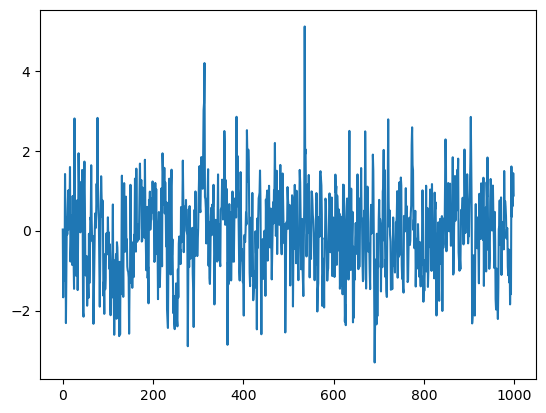

In [109]:
# Example: Generate stationary roots for AR(p)
p = 3
roots = generate_stationary_roots(p)
# TODO plot roots
print("Generated roots:", roots)
print("Magnitudes of roots:", np.abs(roots))
ar_coef = compute_ar_coefficients(roots)
print(ar_coef)
if not np.all(ar_coef.imag == 0):
    print("\nCoefficient are complex.\n")
x, noise = generate_ar_process(ar_coef.real, 1000)
# TODO add some tests to verify stationarity
plt.plot(x)
plt.show()

## Trend

In [49]:
# Generate a trend
if N % 2 == 0:
    adj_to_center = N/2
else:
    adj_to_center = (N - 1)/2
synth_ts["t"] = np.arange(N) - adj_to_center
synth_ts["t2"] = synth_ts["t"]**2

In [50]:
synth_ts

,noise,t,t2
2020-01-01,-0.952578,-15.0,225.0
2020-01-02,0.357504,-14.0,196.0
2020-01-03,1.687633,-13.0,169.0
2020-01-04,0.264103,-12.0,144.0
2020-01-05,2.673997,-11.0,121.0
2020-01-06,-0.481717,-10.0,100.0
2020-01-07,-0.542504,-9.0,81.0
2020-01-08,-0.637542,-8.0,64.0
2020-01-09,0.178654,-7.0,49.0
2020-01-10,-0.983914,-6.0,36.0
